In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import pathlib
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math


2024-07-10 09:15:11.385088: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 09:15:11.390530: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 09:15:11.443176: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-10 09:15:11.504984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 09:15:11.566735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [2]:
root_path = '/home/kmaev/dev/ML_Rebelway_course/ml_course_homework/data'

In [3]:
os.listdir(root_path)

['test', 'Interior', '_temp', 'train', 'val', 'videos.csv', 'Exterior']

In [4]:
num_int = len(os.listdir(root_path + '/' + 'train/Interior'))
num_ext = len(os.listdir(root_path + '/' + 'train/Exterior'))
num_ext, num_int

(800, 800)

In [5]:
data_dir = pathlib.Path(root_path + '/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

In [6]:
class_names

array(['Exterior', 'Interior'], dtype='<U8')

In [7]:
def random_img(dirpath, target_class):
    directory = dirpath + '/' + target_class
    rand_img = random.sample(os.listdir(directory), 1)
    
    img = mpimg.imread(directory + '/' + rand_img[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    print(img.shape)
    return img

(480, 854, 3)


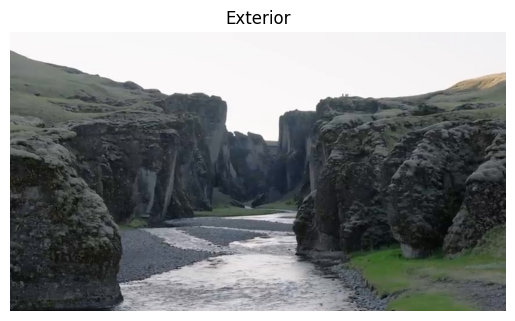

In [8]:
img = random_img(root_path + '/train', class_names[0])

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


In [10]:
train_dir = root_path + '/train'
test_dir = root_path + '/test'
val_dir = root_path + '/val'


In [36]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(480,854),
                                               class_mode = 'binary',
                                               shuffle=True)
test_data = test_datagen.flow_from_directory(test_dir,
                                            batch_size=32,
                                            target_size=(480,854),
                                            class_mode = 'binary',
                                            shuffle=False)
val_data = val_datagen.flow_from_directory(val_dir,
                                           batch_size=32,
                                           target_size=(480,854),
                                           class_mode = 'binary',
                                           shuffle=True)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [37]:

train_dataset = tf.data.Dataset.from_generator( # Converting to tf.data.Dataset to add repeat and avoid running out of data
    lambda: train_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 480, 854, 3], [None])
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_data,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 480, 854, 3], [None])
).repeat()

In [38]:
steps_per_epoch = int((train_data.samples  )// train_data.batch_size)
validation_steps = int((val_data.samples) // val_data.batch_size)
print('Training steps ',steps_per_epoch)
print('Validation steps ',validation_steps)

Training steps  50
Validation steps  6


In [40]:
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation='relu',
                           input_shape = (480,854,3)),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding='valid'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.Conv2D(10, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
    
    ])

baseline_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2,         
    restore_best_weights=True 
)

baseline_model_loss = baseline_model.fit(train_dataset,
                                         epochs=5,
                                         steps_per_epoch=steps_per_epoch,
                                         validation_data=val_dataset,
                                         validation_steps=validation_steps,
                                         callbacks=[early_stopping])

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.5965 - loss: 0.6667 - val_accuracy: 0.6562 - val_loss: 0.5568
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7366 - loss: 0.5380 - val_accuracy: 0.7679 - val_loss: 0.4694
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7283 - loss: 0.5551 - val_accuracy: 0.7321 - val_loss: 0.5082
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7771 - loss: 0.4636 - val_accuracy: 0.7917 - val_loss: 0.4000
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7483 - loss: 0.4964 - val_accuracy: 0.7083 - val_loss: 0.5109


In [41]:

baseline_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 478, 852, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 476, 850, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 238, 425, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 236, 423, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 234, 421, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 117, 210, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 245700)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │       245,701 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 746,135 (2.85 MB)

 Trainable params: 248,711 (971.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 497,424 (1.90 MB)

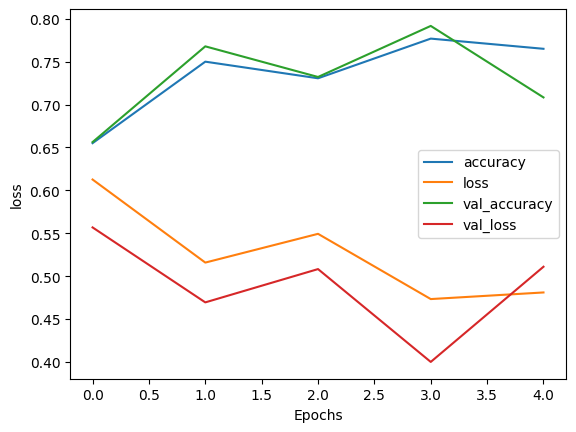

In [42]:
pd.DataFrame(baseline_model_loss.history).plot()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

(1001, 1500, 3)


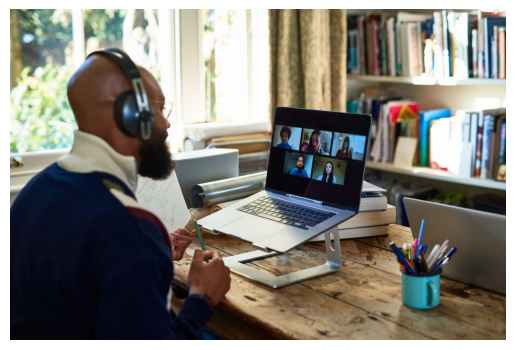

In [43]:
img = mpimg.imread('/home/kmaev/dev/ML_Rebelway_course/ml_course_homework/img/home_office.jpg')
plt.imshow(img)
plt.axis('off')
print(img.shape)

In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [45]:
test_loss, test_accuracy = baseline_model.evaluate(test_data)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

def prepare_image(file_path):
    img = load_img(file_path, target_size=(480, 854))  
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  
    return img_array

file_path = '/home/kmaev/dev/ML_Rebelway_course/ml_course_homework/img/home_office.jpg'

image = prepare_image(file_path)

prediction = baseline_model.predict(image)
print(f"Prediction: {prediction}")

predicted_class = (prediction > 0.5).astype("int32")
print(f"Predicted class: {predicted_class}")

/home/kmaev/dev/test/PycharmProjects/pythonProject/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.8251 - loss: 0.4199
Test loss: 0.4317303001880646
Test accuracy: 0.8199999928474426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Prediction: [[0.602136]]
Predicted class: [[1]]
